In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. Load the dataset
# Assuming you saved the file as 'student_data.csv'
df = pd.read_csv('student_data.csv')

Data Cleaning, NULL Value Remove

In [9]:
# 3. Remove unnecessary columns and clean the data
columns_to_drop = ['S.No.', 'Unnamed: 18', 'Unnamed: 19', 'Group Specialization', 'Group', 'Course Changed', 'Father\'s Name', 'Mobile No.', 'Email ID']
df_clean = df_clean.drop(columns=[col for col in columns_to_drop if col in df_clean.columns])

# Display random 10 rows
print("Random 10 rows from cleaned data:")
print(df_clean.sample(n=10, random_state=42))

print("\nCleaned DataFrame Info:")
print(df_clean.info())

print("\nCleaned DataFrame Shape:", df_clean.shape)

Random 10 rows from cleaned data:
     S.No.  Roll No.      Reg. No           Name Section Specialization  \
431   432.0   1323432  23-MCM-414    GUDDU KUMAR       F            BCA   
169   170.0   1323170  23-MCM-163   ANTRA BANSAL       C          AI&ML   
95     96.0   1323096  23-MCM-089       VANSHIKA       B            BCA   
474   475.0   1323475  23-MCM-453   ADITYA SINGH       F            BCA   
96     97.0   1323097  23-MCM-090      TANU RANI       B            BCA   
372   373.0   1323373  23-MCM-356   AKSHAY KUMAR       E            BCA   
574   575.0   1323575  23-MCM-602  SURESH DEWALI       A             AI   
268   269.0   1323269  23-MCM-260   UJJWAL TOMER       D  Data Science    
174   175.0   1323175  23-MCM-166    RAJAT KUMAR       C          AI&ML   
585   586.0   1323586  23-MCM-556  KHUSHI TANWAR       F             AI   

     1st Sem.  2nd Sem.  3rd Sem.  4th Sem.  5th Sem.  6th Sem.  
431      0.00      7.32      6.68      6.27       NaN       NaN  
169     

Data Visualization to show the trends

In [3]:
# 2. Define a function to clean the Semester columns
def clean_grade(value):
    value = str(value).upper().strip()
    
    # Handle explicit missing/special cases
    if value in ['NAN', 'ABSENT', 'RL(REGN.)', 'RLS', 'RLA', '']:
        return np.nan  # Return Not a Number (missing)
    
    # Handle Re-appears (RE). 
    # Logic: If they have a Re-appear, their GPA for that sem is technically 
    # undetermined or could be treated as a fail (0). 
    # For this model, we will treat RE as NaN (missing) to avoid skewing averages, 
    # OR you can set it to 0.0 if you want to penalize it.
    if 'RE' in value or '[' in value:
        return 0.0 # Treating Backlog as 0 for the model
        
    try:
        # Try to convert grade to a float number
        return float(value)
    except ValueError:
        return np.nan

In [4]:
# 3. Apply cleaning to Semester Columns
sem_cols = ['1st Sem.', '2nd Sem.', '3rd Sem.', '4th Sem.', '5th Sem.', '6th Sem.']

# Check if columns exist in your CSV, names might vary slightly
existing_sem_cols = [col for col in sem_cols if col in df.columns]

for col in existing_sem_cols:
    df[col] = df[col].apply(clean_grade)

# 4. Drop rows where there is absolutely no grade data if necessary
df_clean = df.dropna(subset=['1st Sem.']) 

print("Data Cleaning Complete.")
print(df_clean[existing_sem_cols].head())

Data Cleaning Complete.
   1st Sem.  2nd Sem.  3rd Sem.  4th Sem.  5th Sem.  6th Sem.
1      6.20      0.00      0.00      0.00       NaN       NaN
3      6.61      6.23      0.00      6.39       NaN       NaN
4      8.77      0.00       NaN       NaN       NaN       NaN
5      8.05      8.45      8.36      7.32       NaN       NaN
6      7.45      8.18      7.95      7.55       NaN       NaN


Step 2: Data Visualization (EDA)

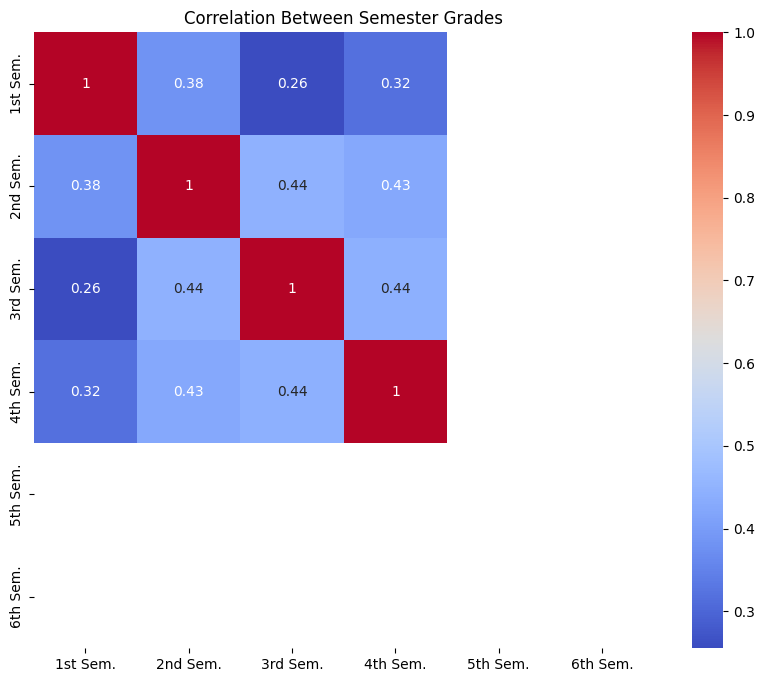

In [5]:
# 1. Heatmap: Check correlation between semesters
# (e.g., Does doing well in Sem 1 predict doing well in Sem 2?)
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean[existing_sem_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Semester Grades')
plt.show()

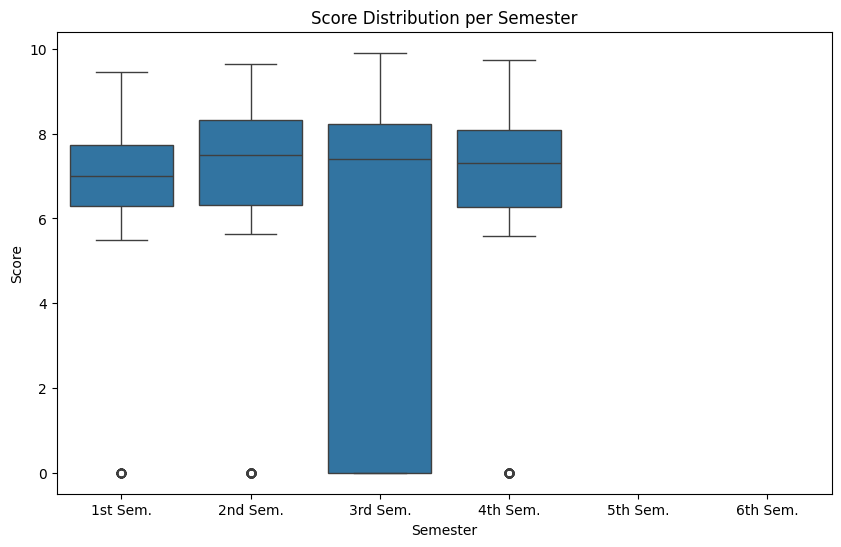

In [6]:
# 2. Distribution: How many students are passing vs failing/backlogs (0.0 scores)
plt.figure(figsize=(10, 6))
# Melt data to long format for plotting
df_melted = df_clean.melt(id_vars=['Name'], value_vars=existing_sem_cols, var_name='Semester', value_name='Score')
sns.boxplot(x='Semester', y='Score', data=df_melted)
plt.title('Score Distribution per Semester')
plt.show()

Algorithm: Linear Regression.Equation: $$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 ...$$

Model Accuracy (R2 Score): 0.12176756325877913
Mean Squared Error: 6.257401508919449


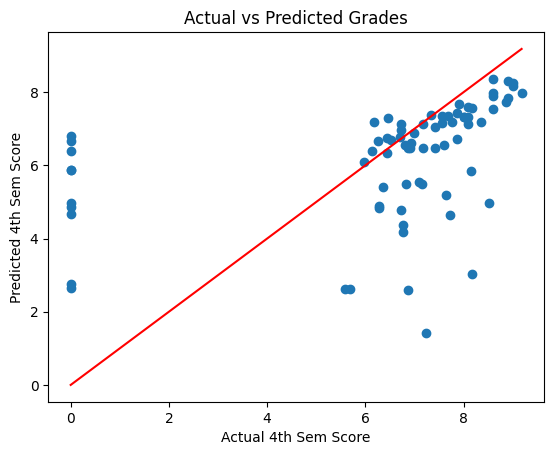

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# 1. Select Features (Input) and Target (Output)
# We need rows where we have data for 1st, 2nd, 3rd (Inputs) and 4th (Target)
ml_data = df_clean[['1st Sem.', '2nd Sem.', '3rd Sem.', '4th Sem.']].dropna()

X = ml_data[['1st Sem.', '2nd Sem.', '3rd Sem.']] # Inputs
y = ml_data['4th Sem.'] # Target

# 2. Split into Training and Testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize and Train Model
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Make Predictions
predictions = model.predict(X_test)

# 5. Evaluate
print("Model Accuracy (R2 Score):", r2_score(y_test, predictions))
print("Mean Squared Error:", mean_squared_error(y_test, predictions))

# 6. Visualize Actual vs Predicted
plt.scatter(y_test, predictions)
plt.xlabel('Actual 4th Sem Score')
plt.ylabel('Predicted 4th Sem Score')
plt.title('Actual vs Predicted Grades')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Diagonal line
plt.show()

Model Accuracy to Predict the Output 5th Sem Result

In [8]:
# 1. Find student data
student_roll = '1323607'
student_data = df_clean[df_clean['Roll No.'] == student_roll]

if student_data.empty:
    print(f"Student {student_roll} not found in dataset.")
else:
    student_name = student_data['Name'].values[0]
    
    # 2. Extract 1st, 2nd, 3rd semester grades
    input_features = student_data[['1st Sem.', '2nd Sem.', '3rd Sem.']].values
    
    # 3. Predict 4th semester grade
    predicted_4th_sem = model.predict(input_features)[0]
    
    # 4. Display results
    print(f"Student Name: {student_name}")
    print(f"Roll No: {student_roll}")
    print(f"1st Sem: {input_features[0][0]}")
    print(f"2nd Sem: {input_features[0][1]}")
    print(f"3rd Sem: {input_features[0][2]}")
    print(f"\nPredicted 4th Sem Grade: {predicted_4th_sem:.2f}")
    
    # 5. Visualization - Effectiveness Table
    actual_4th_sem = student_data['4th Sem.'].values[0]
    
    effectiveness_data = {
        'Semester': ['1st', '2nd', '3rd', '4th (Predicted)', '4th (Actual)'],
        'Score': [input_features[0][0], input_features[0][1], input_features[0][2], predicted_4th_sem, actual_4th_sem]
    }
    
    effectiveness_df = pd.DataFrame(effectiveness_data)
    
    plt.figure(figsize=(10, 6))
    plt.bar(effectiveness_df['Semester'], effectiveness_df['Score'], color=['blue', 'blue', 'blue', 'orange', 'green'])
    plt.ylabel('Grade')
    plt.title(f'Student Performance: {student_name} ({student_roll})')
    plt.ylim(0, 10)
    for i, v in enumerate(effectiveness_df['Score']):
        plt.text(i, v + 0.2, f'{v:.2f}', ha='center')
    plt.show()
    
    print("\nEffectiveness Table:")
    print(effectiveness_df.to_string(index=False))

KeyError: 'Roll No.'